<a href="https://colab.research.google.com/github/obeabi/SDSDecember2020Challenge/blob/main/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS October Challenge #4 - Hostel Price Prediction
2021-02-12

This month’s challenge is to build a data driven model determine a fair price for new hostels based on previous hostel data. Specifically, my objective is to predict the price of each hostel based on the data provided.

## Step 1: Data Preprocessing

In [1]:
# Install libraries not inbuilt
!pip install category_encoders

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import  zscore
import category_encoders as ce
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Libraries installed successfully!


In [3]:
# Importing the training dataset

df_train = pd.read_csv('public_listings.csv', engine= 'python', encoding= 'latin1')

df_train.head()

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100%,77%,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60
2,Modern New Condo 20 minutes to upper west side,Modern homey condo - (keyed)private bedroom & ...,Safe neighborhood. Security cameras outside th...,https://a0.muscache.com/pictures/a0073afa-b976...,Shanthi,3/5/16,"New York, New York, United States",NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/3a42b...,https://a0.muscache.com/im/pictures/user/3a42b...,Kingsbridge Heights,2,2.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Bronx, New York, United States",Kingsbridge,Bronx,40.87870,-73.90098,Private room in condominium,Private room,1.0,1 private bath,1.0,1.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Hot water"", ""Loc...",30.0,120,30.0,30.0,120.0,120.0,30,120.0,t,28.0,58,88,178.0,10/9/20,9.0,1.0,0.0,5/11/18,12/17/19,89,9.0,7.0,10.0,10.0,9.0,9.0,f,2.0,0.0,2.0,0.0,0.31,39
3,Lower East Side Apartment,The apartment is located in the heart of the L...,NaN,https://a0.muscache.com/pictures/0a84b409-935d...,Sabina,1/30/16,"New York, New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/98125...,https://a0.muscache.com/im/pictures/user/98125

In [4]:
 #Importing the test dataset

df_test = pd.read_csv('pred_listings.csv', engine= 'python', encoding= 'latin1')

df_test.head()

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Heart of Park Slope,"This two room private suite, suitable for a co...",Park Slope is a beautiful neighborhood of tree...,https://a0.muscache.com/pictures/c6fda99b-1b21...,Nancy,5/2/18,"Brooklyn, New York, United States",I am an artist and I run a small gallery in my...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/9c243...,https://a0.muscache.com/im/pictures/user/9c243...,Park Slope,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, New York, United States",Park Slope,Brooklyn,40.67384,-73.97743,Private room in condominium,Private room,2.0,1 private bath,1.0,1.0,"[""Private entrance"", ""Hot water"", ""Extra pillo...",2.0,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28.0,58,88,177.0,10/8/20,58.0,16.0,0.0,6/6/18,7/30/20,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.0,0.0,1.0,0.0,2.03
1,"Gramercy Park restful, cozy, sun-filled home","In the charming Gramercy Park neighborhood, ou...",The Gramercy Park area is a quiet residential ...,https://a0.muscache.com/pictures/6cc018db-208a...,Javier,3/3/15,"New York, New York, United States",I am passionate about history and culture born...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/a8830...,https://a0.muscache.com/im/pictures/user/a8830...,Gramercy Park,5,5.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,"New York, United States",Gramercy,Manhattan,40.73618,-73.9833,Entire apartment,Entire home/apt,2.0,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Carbon monoxide a...",2.0,15,2.0,3.0,1125.0,1125.0,2,1125.0,t,18.0,48,77,77.0,10/12/20,76.0,17.0,0.0,9/20/17,3/8/20,97,10.0,10.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,2.04
2,Serene art-filled apartment near Prospect Park,Serene Brooklyn apartment near Prospect Park. ...,NaN,https://a0.muscache.com/pictures/550be13c-4fbb...,Dara,6/19/12,"New York, New York, United States",Documentary filmmaker and writer living in Bro...,NaN,NaN,50%,f,https://a0.muscache.com/im/users/2681144/profi...,https://a0.muscache.com/im/users/2681144/profi...,Flatbush,1.0,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Flatbush,Brooklyn,40.65120,-73.95908,Entire apartment,Entire home/apt,3.0,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Washer"", ""Shower ge...",10.0,90,10.0,10.0,90.0,90.0,10.0,90.0,t,0.0,0,0,0.0,10/10/20,21.0,2.0,0.0,12/15/18,12/18/19,96.0,10.0,9.0,9.0,10.0,9.0,9.0,f,1.0,1.0,0.0,0.0,0.95
3,Sunny bdr w stunning view in prime Williamsbur...,Beautiful new apartment in prime Williamsburg....,The place is super close to all the best bars ...,https://a0.muscache.com/pictures/d578e2bb-6bfd...,Cristina,9/16/13,"New York, New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/6dca6...,https://a0.muscache.com/im/pictures/user/6dca6...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'ju

In [5]:
# priniting the details about the train dataset

print("\nEDA on Training Set\n")
print("#"*30)

print("\n\nNumber of Features/Columns : ", len(df_train.columns))
print("\nNumber of Rows : ",df_train.shape[0])


print("\n Contains NaN/Empty cells : ", df_train.isnull().values.any())

print("\n Total empty cells by column :\n", df_train.isnull().sum(), "\n\n")

print("\n Perecentage of missing values in train dataframe is: \n", str(100*(df_train.isnull().sum().sum()/(df_train.shape[0]* df_train.shape[1])))+'%')


EDA on Training Set

##############################


Number of Features/Columns :  65

Number of Rows :  35734

 Contains NaN/Empty cells :  True

 Total empty cells by column :
 name                                               13
description                                      1018
neighborhood_overview                           13151
picture_url                                         1
host_name                                          14
                                                ...  
calculated_host_listings_count_entire_homes         3
calculated_host_listings_count_private_rooms        3
calculated_host_listings_count_shared_rooms         3
reviews_per_month                                8402
price                                               2
Length: 65, dtype: int64 



 Perecentage of missing values in train dataframe is: 
 8.277572318541704%


In [6]:
# Check for missing values in train set
df_train.isnull().sum()

name                                               13
description                                      1018
neighborhood_overview                           13151
picture_url                                         1
host_name                                          14
                                                ...  
calculated_host_listings_count_entire_homes         3
calculated_host_listings_count_private_rooms        3
calculated_host_listings_count_shared_rooms         3
reviews_per_month                                8402
price                                               2
Length: 65, dtype: int64

In [7]:
# Drop missing values in price column

# Handle the missing values in target field if applicable

print("Original Length of Training Set : ", len(df_train))
df_train.dropna(subset=['price'], axis = 0, inplace= True)
print("Length of Training Set after dropping NaN in target column: ", len(df_train))

Original Length of Training Set :  35734
Length of Training Set after dropping NaN in target column:  35732


In [8]:
# priniting the details about the test dataset

print("#"*30)
print("\nEDA on Test Set\n")
print("#"*30)


print("\n\nNumber of Features/Columns : ",len(df_test.columns))
print("\nNumber of Rows : ",df_test.shape[0])

print("\n Contains NaN/Empty cells : ", df_test.isnull().values.any())
print("\n Total empty cells by column :\n", df_test.isnull().sum())
print("\n Perecentage of missing values in test datframe is: \n",str(100*(df_test.isnull().sum().sum()/(df_test.shape[0]* df_test.shape[1]))) +'%')

##############################

EDA on Test Set

##############################


Number of Features/Columns :  64

Number of Rows :  8934

 Contains NaN/Empty cells :  True

 Total empty cells by column :
 name                                               4
description                                      265
neighborhood_overview                           3310
picture_url                                        1
host_name                                          3
                                                ... 
calculated_host_listings_count                     1
calculated_host_listings_count_entire_homes        1
calculated_host_listings_count_private_rooms       1
calculated_host_listings_count_shared_rooms        1
reviews_per_month                               2119
Length: 64, dtype: int64

 Perecentage of missing values in test datframe is: 
 8.425677188269534%


In [9]:
# Check data type for train set
for cols in df_train.columns:
  print(cols,':', df_train[cols].dtype)


name : object
description : object
neighborhood_overview : object
picture_url : object
host_name : object
host_since : object
host_location : object
host_about : object
host_response_time : object
host_response_rate : object
host_acceptance_rate : object
host_is_superhost : object
host_thumbnail_url : object
host_picture_url : object
host_neighbourhood : object
host_listings_count : object
host_total_listings_count : float64
host_verifications : object
host_has_profile_pic : object
host_identity_verified : object
neighbourhood : object
neighbourhood_cleansed : object
neighbourhood_group_cleansed : object
latitude : float64
longitude : object
property_type : object
room_type : object
accommodates : float64
bathrooms_text : object
bedrooms : float64
beds : float64
amenities : object
minimum_nights : float64
maximum_nights : object
minimum_minimum_nights : float64
maximum_minimum_nights : float64
minimum_maximum_nights : float64
maximum_maximum_nights : float64
minimum_nights_avg_ntm : ob

In [10]:
# Convert object columns to numerical columns
df_train[['price', 'host_response_rate','host_acceptance_rate','review_scores_rating']]= df_train[['price', 'host_response_rate','host_acceptance_rate','review_scores_rating']].replace({',':'', ' ': '', '%':''} , regex = True)

df_test[[ 'host_response_rate','host_acceptance_rate','review_scores_rating']]= df_test[['host_response_rate','host_acceptance_rate','review_scores_rating']].replace({',':'', ' ': '', '%':''} , regex = True)

df_train['price']= df_train.price.astype(float)
df_train['host_response_rate']= df_train.host_response_rate.astype(float)


# test set
df_test['host_response_rate']= df_test.host_response_rate.astype(float)


df_train.head(2)


,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100.0,77,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763000000002,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110.0
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60.0


In [11]:
# Find error line in host acceptance-rate column in train set
df_train.host_acceptance_rate.value_counts()

100                                                7270
0                                                  1195
99                                                  870
50                                                  794
97                                                  759
                                                   ... 
8                                                     4
12                                                    3
15                                                    2
5                                                     2
['email''phone''reviews''jumio''government_id']       1
Name: host_acceptance_rate, Length: 97, dtype: int64

In [12]:
# Find error line in host acceptance-rate column in test set
df_test.host_acceptance_rate.value_counts()

100                                                     1775
0                                                        309
99                                                       244
97                                                       229
98                                                       204
                                                        ... 
6                                                          1
41                                                         1
7                                                          1
['email''phone''facebook''reviews''kba''work_email']       1
16                                                         1
Name: host_acceptance_rate, Length: 94, dtype: int64

In [13]:
# drop problematic row in host_acceptance_rate
to_drop_train =  "['email''phone''reviews''jumio''government_id']"
to_drop_test = "['email''phone''facebook''reviews''kba''work_email']"

index_train= df_train[ df_train['host_acceptance_rate'] == to_drop_train].index
index_test= df_test[ df_test['host_acceptance_rate'] == to_drop_test].index

# drop indexes
df_train.drop(index_train, inplace = True) 
df_test.drop(index_test, inplace = True) 

# Change data type to float
df_train['host_acceptance_rate']= df_train.host_acceptance_rate.astype(float)
df_test['host_acceptance_rate']= df_test.host_acceptance_rate.astype(float)

In [14]:
df_train['review_scores_rating']= df_train.review_scores_rating.astype(float)
df_test['review_scores_rating']= df_test.review_scores_rating.astype(float)

# Address lonitude column
df_train['longitude']= df_train.longitude.astype(float)
df_test['longitude']= df_test.longitude.astype(float)

df_train.head(2)

,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100.0,77.0,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110.0
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60.0


## Explore numerical columns only

In [15]:

# Define continous features as one new dataframe
# Extract numerical columns from train dataframe
numerical_cols = [cname for cname in df_train.columns if
                df_train[cname].dtype in ['int64', 'float64']]


num_df_train = df_train[numerical_cols].copy()

#num_df_train.drop( ['price_category'], axis = 1, inplace= True)

num_df_train.head()

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,100.0,77.0,1.0,40.85502,-73.92763,2.0,1.0,1.0,6.0,6.0,6.0,1125.0,1125.0,1125.0,19.0,354.0,23.0,6.0,1.0,95.0,10.0,8.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,1.03,110.0
1,NaN,NaN,1.0,40.71172,-73.93973,2.0,1.0,1.0,2.0,2.0,2.0,1125.0,1125.0,1125.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,NaN,60.0
2,100.0,100.0,2.0,40.87870,-73.90098,1.0,1.0,1.0,30.0,30.0,30.0,120.0,120.0,120.0,28.0,178.0,9.0,1.0,0.0,89.0,9.0,7.0,10.0,10.0,9.0,9.0,2.0,0.0,2.0,0.0,0.31,39.0
3,NaN,NaN,2.0,40.71731,-73.99108,6.0,3.0,3.0,3.0,3.0,3.0,1125.0,1125.0,1125.0,0.0,0.0,4.0,0.0,0.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2.0,1.0,1.0,0.0,0.10,120.0
4,NaN,100.0,1.0,40.72392,-73.98915,2.0,1.0,1.0,30.0,30.0,30.0,1125.0,1125.0,1125.0,0.0,2.0,9.0,4.0,0.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1.0,1.0,0.0,0.0,0.50,110.0


In [16]:
# Check for outliers
from scipy import stats
zscore = np.abs(stats.zscore(num_df_train))
zscore

array([[       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.12843728],
       [       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.29038091],
       [       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.35839724],
       ...,
       [       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.34220287],
       [       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.3250049 ],
       [       nan,        nan,        nan, ..., 0.09469859,        nan,
        0.24403308]])

In [ ]:

## For simplicity remove all data with outliers
df_clean = df_train.copy()
df_clean = df_train[(zscore <3).all(axis = 1)]
print("The shape of the original dataframe is :", df_train.shape)
print("The shape of the clean dataframe is :", df_clean.shape)

deleted_entries = df_train.shape[0] - df_clean.shape[0]
print("Entries deleted in the dataframe are :",  deleted_entries)

In [ ]:
# Check for correlation between independent and dependent varaible
df_clean.corr()

In [820]:
# View the first three rows for contious columns of the dataframe
X_full = df_train.copy()
X_test_full = df_test.copy()
print(X_full.shape)

X_full.head()

(35731, 65)


,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Quiet and safe one bedroom in Upper Manhattan,Cozy yet spacious one bedroom with lots of lig...,Safe and family-oriented with well lit streets...,https://a0.muscache.com/pictures/0f3679a5-e907...,Mark,12/3/18,"New York, New York, United States",My name is Mark and I own a small Internet mar...,within an hour,100.0,77.0,t,https://a0.muscache.com/im/pictures/user/9abd1...,https://a0.muscache.com/im/pictures/user/9abd1...,Washington Heights,1.0,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,t,"New York, United States",Washington Heights,Manhattan,40.85502,-73.92763,Entire apartment,Entire home/apt,2.0,1 bath,1.0,1.0,"[""Hot water"", ""Smoke alarm"", ""Laptop-friendly ...",6.0,30,6.0,6.0,1125.0,1125.0,6.0,1125.0,t,19.0,49,79,354.0,10/9/20,23.0,6.0,1.0,12/9/18,9/24/20,95.0,10.0,8.0,10.0,10.0,10.0,9.0,f,1.0,1.0,0.0,0.0,1.03,110.0
1,Big Sunny Room 10secs from L train,My large two bedroom apt is a great place to s...,Williamsburg is such a cool place to live. The...,https://a0.muscache.com/pictures/60023372/29c3...,Lauren,1/23/12,"New York, New York, United States",Iv'e seen over 300 films. I am an actor living...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1641589/profi...,https://a0.muscache.com/im/users/1641589/profi...,Williamsburg,1,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71172,-73.93973,Private room in apartment,Private room,2.0,1 bath,1.0,1.0,"[""Shampoo"", ""Heating"", ""Essentials"", ""Kitchen""...",2.0,1125,2.0,2.0,1125.0,1125.0,2,1125.0,t,0.0,0,0,0.0,10/12/20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,60.0
2,Modern New Condo 20 minutes to upper west side,Modern homey condo - (keyed)private bedroom & ...,Safe neighborhood. Security cameras outside th...,https://a0.muscache.com/pictures/a0073afa-b976...,Shanthi,3/5/16,"New York, New York, United States",NaN,within an hour,100.0,100.0,f,https://a0.muscache.com/im/pictures/user/3a42b...,https://a0.muscache.com/im/pictures/user/3a42b...,Kingsbridge Heights,2,2.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Bronx, New York, United States",Kingsbridge,Bronx,40.87870,-73.90098,Private room in condominium,Private room,1.0,1 private bath,1.0,1.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Hot water"", ""Loc...",30.0,120,30.0,30.0,120.0,120.0,30,120.0,t,28.0,58,88,178.0,10/9/20,9.0,1.0,0.0,5/11/18,12/17/19,89.0,9.0,7.0,10.0,10.0,9.0,9.0,f,2.0,0.0,2.0,0.0,0.31,39.0
3,Lower East Side Apartment,The apartment is located in the heart of the L...,NaN,https://a0.muscache.com/pictures/0a84b409-935d...,Sabina,1/30/16,"New York, New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/98125...,https://a0.muscache.com/im/pictures/user/98

In [789]:
# Remove rows with missing target, separate target from predictors
y = X_full.price
X_full.drop(['price'], axis=1, inplace=True)

In [790]:
# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

In [791]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
#Step 1: Preliminary investigation
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

(28584, 31)


In [792]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

host_response_rate             14759
host_acceptance_rate           10746
host_total_listings_count         13
bedrooms                        2715
beds                             321
minimum_minimum_nights             4
maximum_minimum_nights             4
minimum_maximum_nights             4
maximum_maximum_nights             4
maximum_nights_avg_ntm             4
review_scores_rating            7421
review_scores_accuracy          7440
review_scores_cleanliness       7432
review_scores_checkin           7449
review_scores_communication     7440
review_scores_location          7451
review_scores_value             7453
reviews_per_month               6727
dtype: int64


In [796]:
print("Total missing values is :" ,  X_train.isnull().sum().sum())

Total missing values is : 87387


In [797]:
# KNN Imputer class
from sklearn.impute import KNNImputer
# Imputation
my_KNNimputer = KNNImputer(n_neighbors=4)
KNNimputed_X_train = pd.DataFrame(my_KNNimputer.fit_transform(X_train))
KNNimputed_X_valid = pd.DataFrame(my_KNNimputer.transform(X_valid))


In [798]:
# Imputation removed column names; put them back
KNNimputed_X_train.columns = X_train.columns
KNNimputed_X_valid.columns = X_valid.columns

In [799]:
# Let's print the basic statistics
KNNimputed_X_train.describe()

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,2.858400e+04,2.858400e+04,2.858400e+04,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000,28584.000000
mean,80.772845,75.030096,15.895676,40.729536,-73.950695,2.768332,1.289025,1.513425,9.332249,9.550413,13.149104,1.203479e+06,2.330417e+06,2.254595e+06,8.086482,105.596558,22.110726,4.140253,0.189826,93.315019,9.532448,9.186468,9.674529,9.677145,9.560383,9.321823,6.593969,3.578261,2.815246,0.085712,0.687994
std,25.065156,26.033758,118.895368,0.055508,0.047471,1.830519,0.669394,1.093522,24.122186,30.198935,56.771062,5.079433e+07,7.068406e+07,6.946188e+07,12.028739,139.684178,46.007300,9.864762,0.853015,9.140376,0.897919,1.103853,0.789980,0.797019,0.761224,0.959733,24.548381,19.587828,13.870866,0.912159,1.121446
min,0.000000,0.000000,0.000000,40.522110,-74.208770,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,70.000000,59.250000,1.000000,40.689750,-73.982790,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.100000e+01,3.100000e+01,3.100000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,90.000000,9.000000,9.000000,9.750000,9.750000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.070000
50%,92.000000,82.000000,1.000000,40.724445,-73.955350,2.000000,1.000000,1.000000,3.000000,3.000000,3.000000,1.125000e+03,1.125000e+03,1.125000e+03,0.000000,1.000000,4.000000,0.000000,0.000000,96.000000,10.000000,9.500000,10.000000,10.000000,10.000000,9.750000,1.000000,1.000000,1.000000,0.000000,0.230000
75%,100.000000,98.000000,2.000000,40.763340,-73.933710,4.000000,1.000000,2.000000,7.000000,7.000000,7.000000,1.125000e+03,1.125000e+03,1.125000e+03,20.000000,190.000000,20.000000,4.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,0.810000
max,100.000000,100.000000,2114.000000,40.910550,-73.711930,16.000000,21.000000,24.000000,1124.000000,1124.000000,1124.000000,2.147484e+09,2.147484e+09,2.147484e+09,30.000000,365.000000,573.000000,473.000000,36.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,239.000000,239.000000,134.000000,28.000000,35.450000


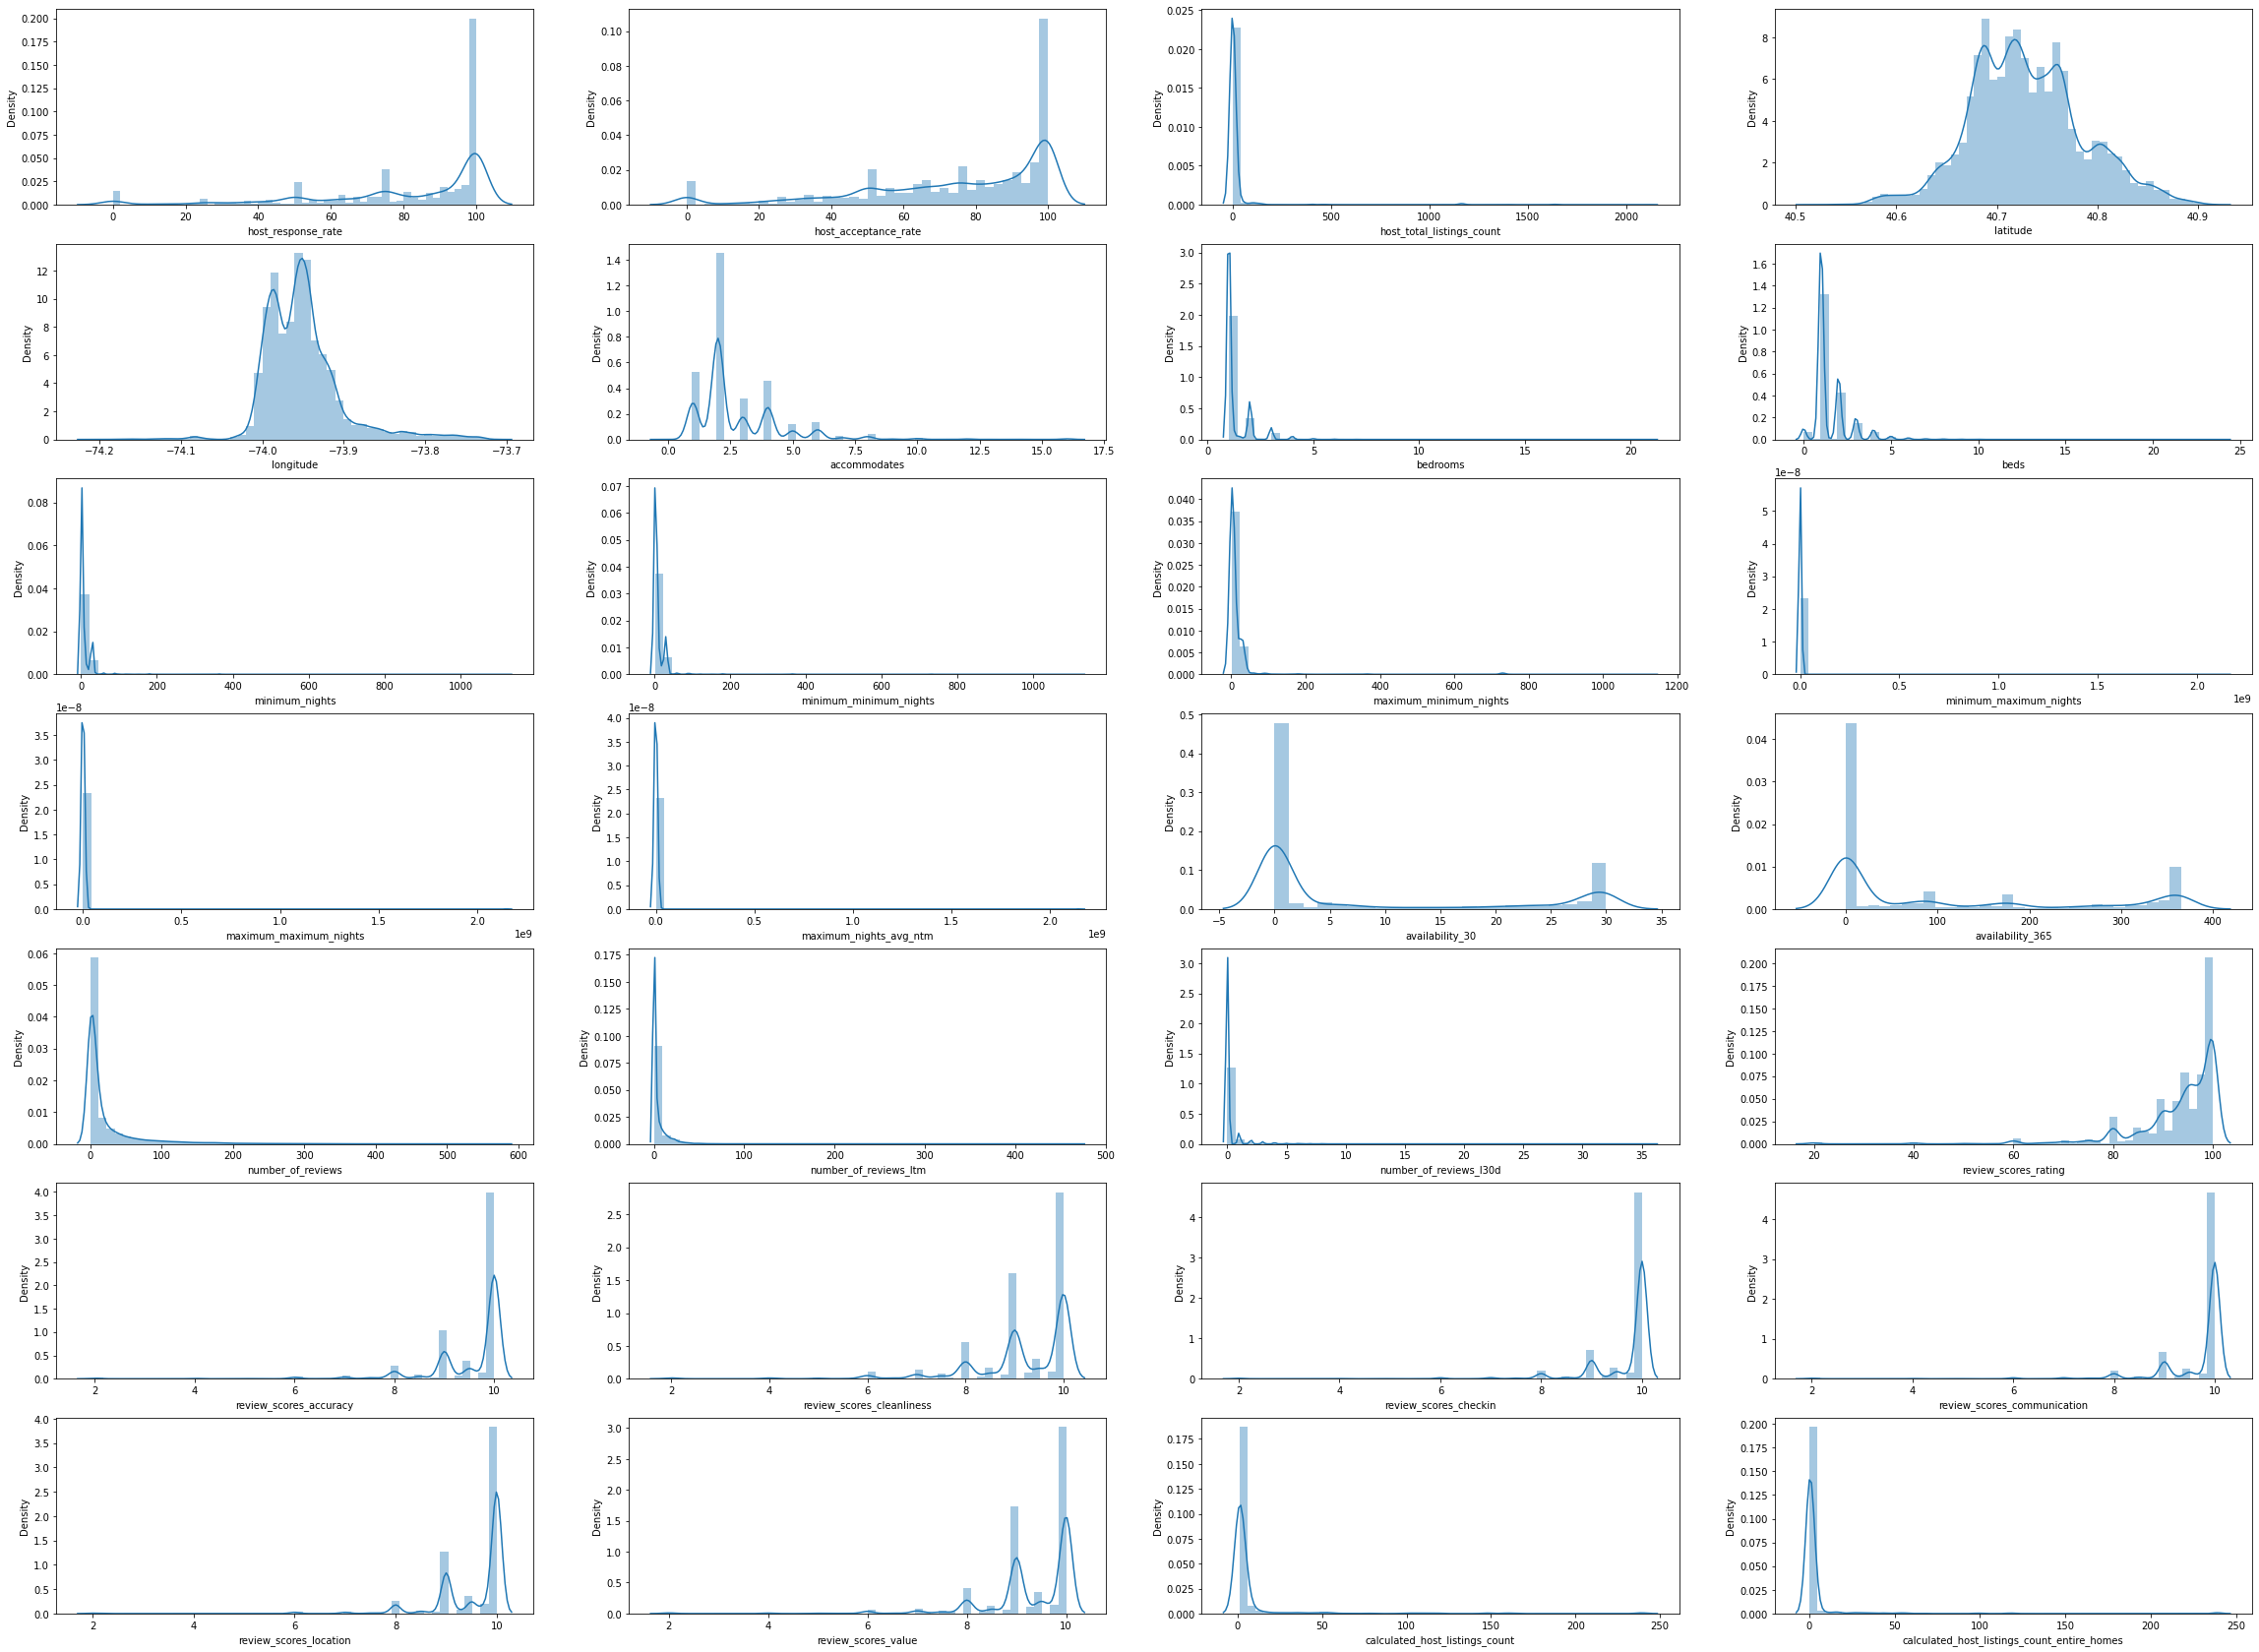

In [800]:
# let's see how data is distributed for every column
plt.figure(figsize=(40,30), facecolor='white')
plotnumber = 1

for column in KNNimputed_X_train.columns:
    if plotnumber<=28 :     # as there are 28 columns in the data
        ax = plt.subplot(7,4,plotnumber)
        sns.distplot(KNNimputed_X_train[column])
        plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

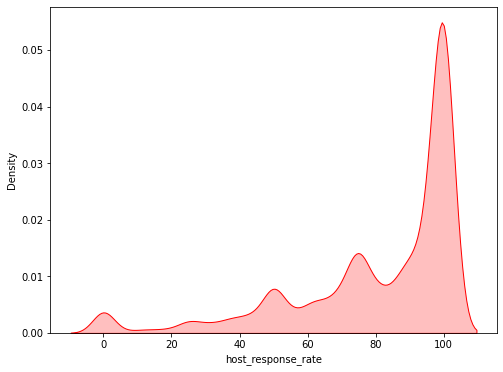

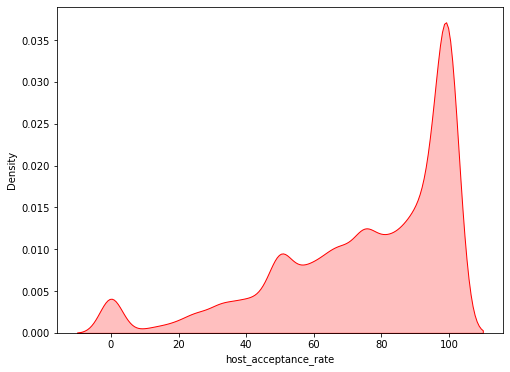

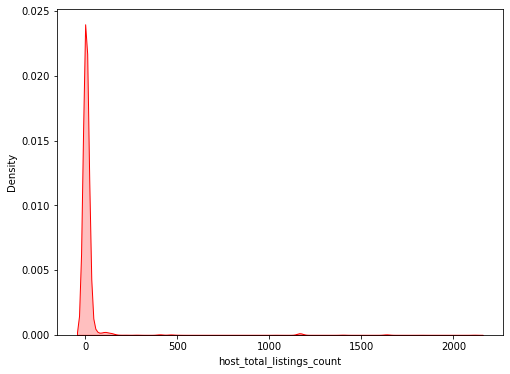

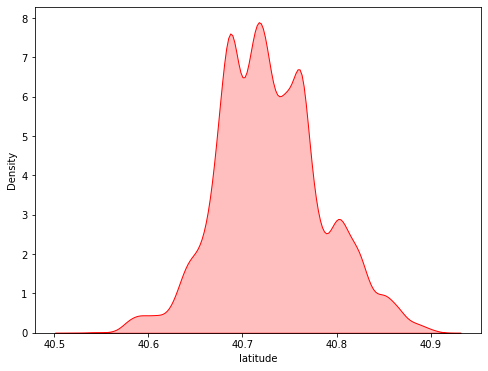

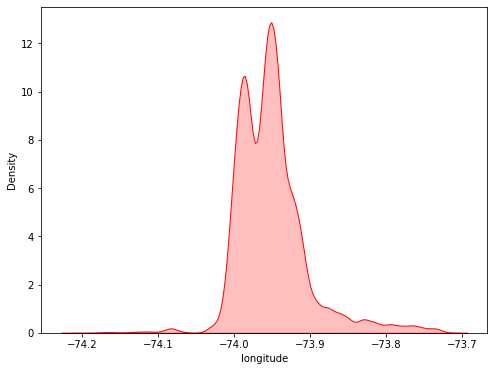

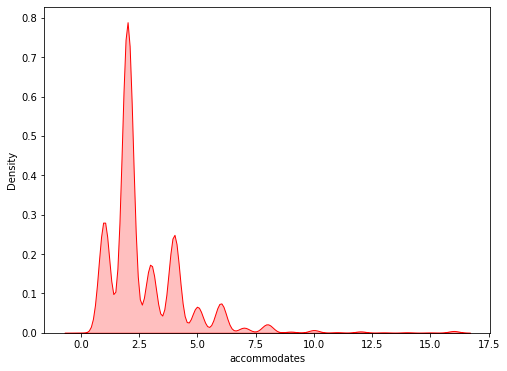

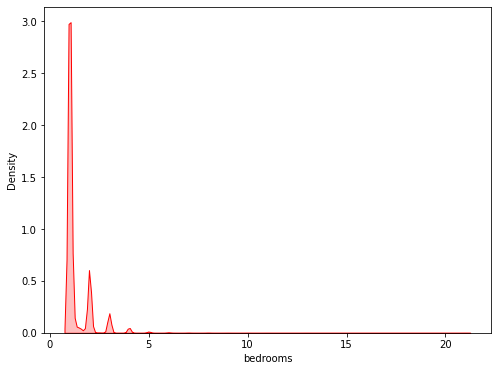

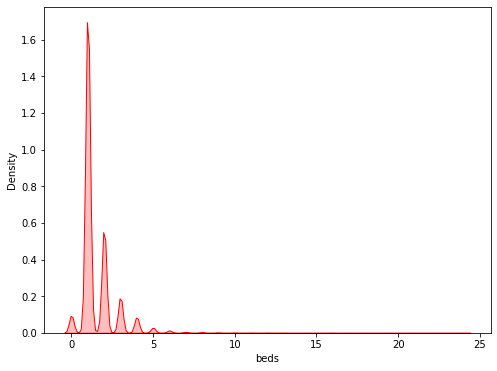

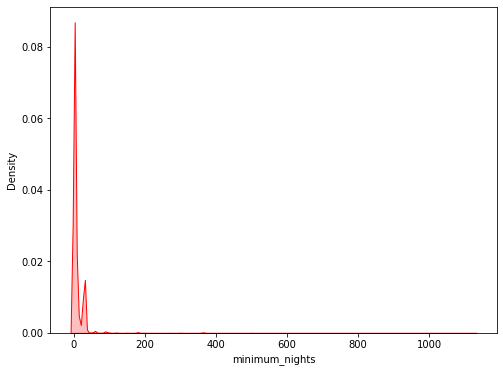

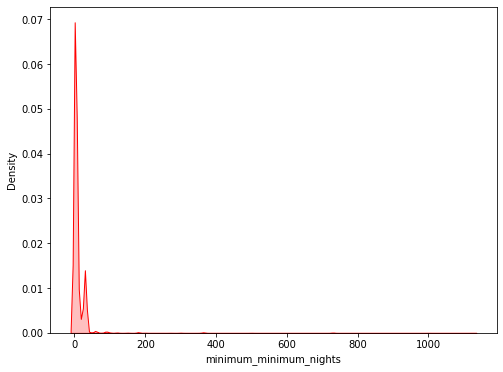

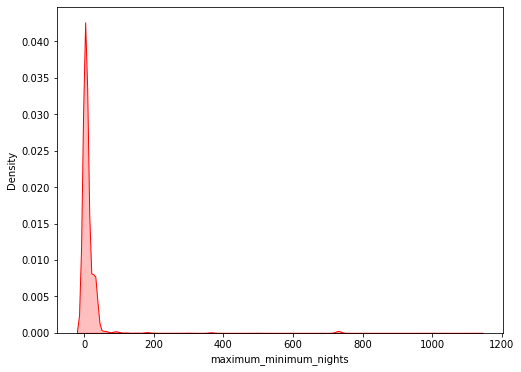

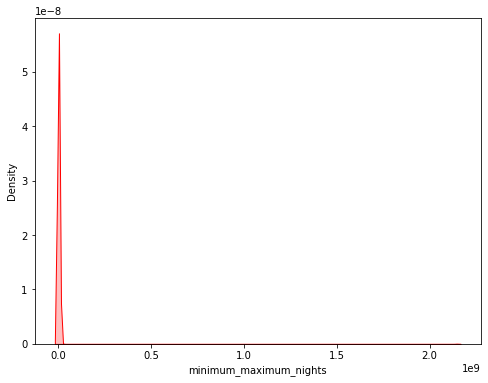

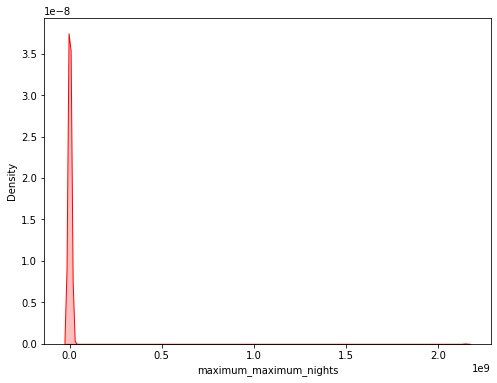

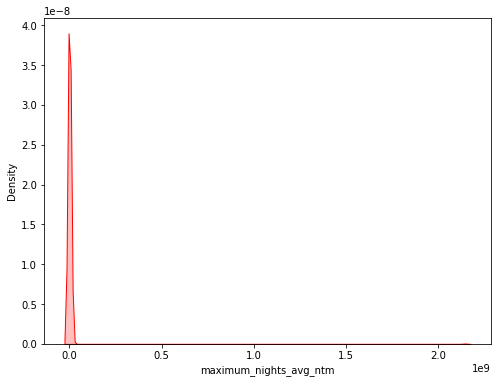

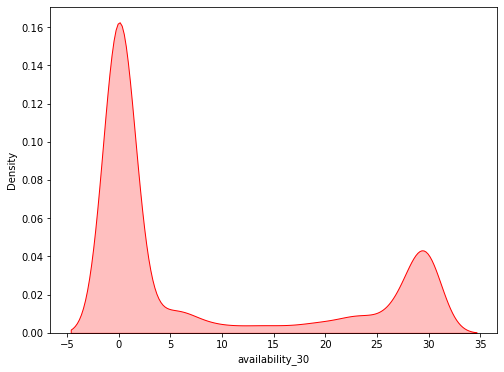

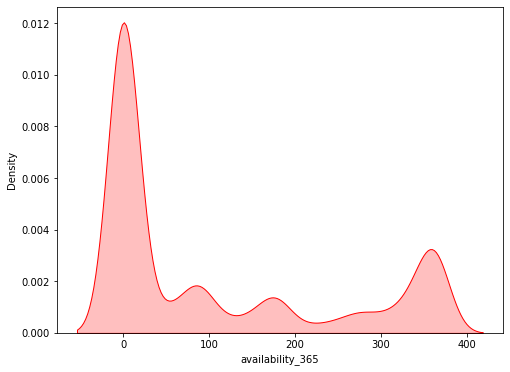

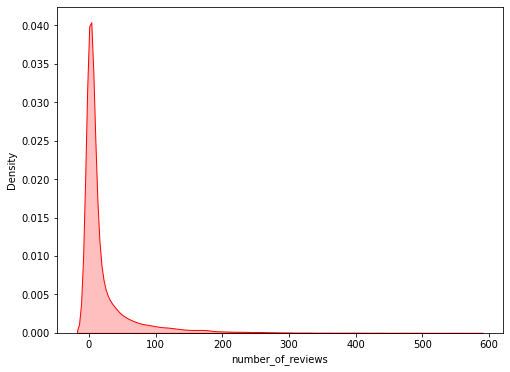

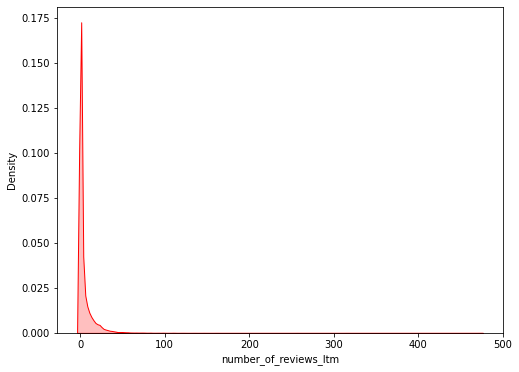

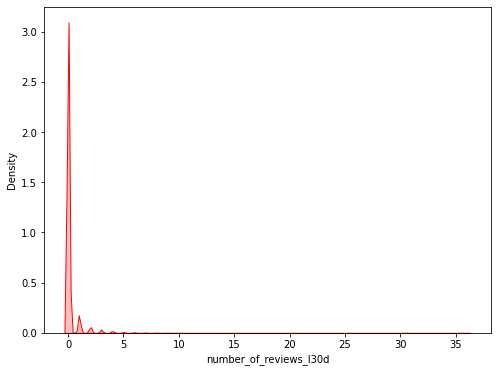

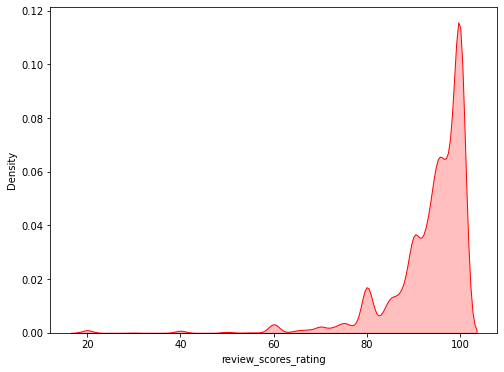

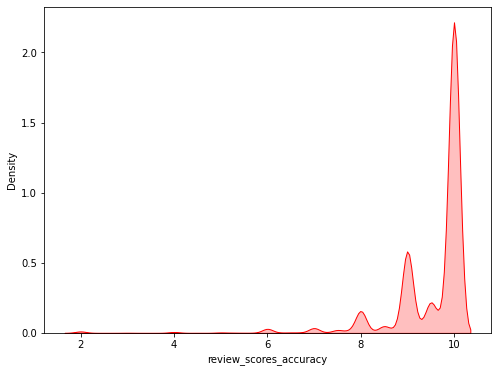

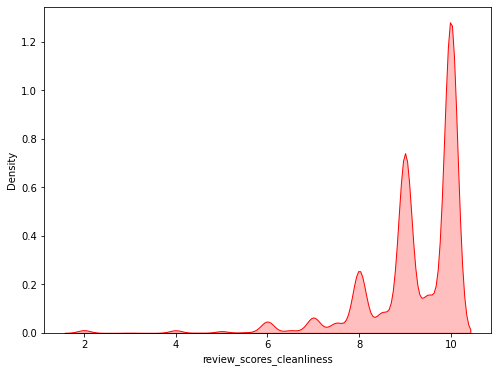

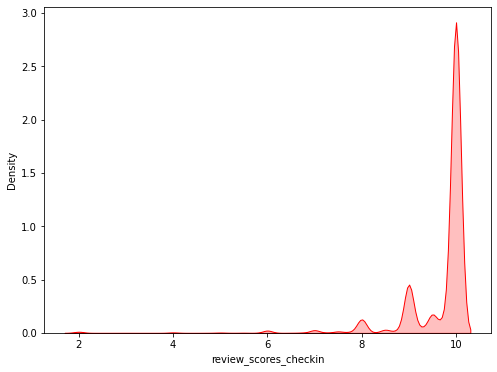

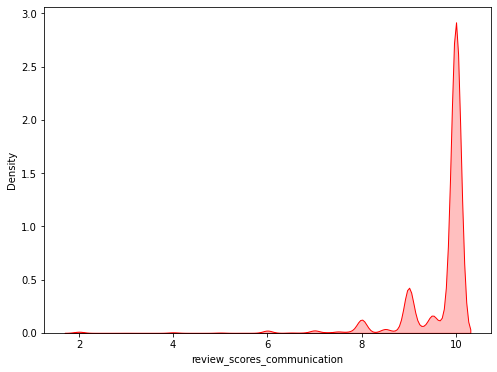

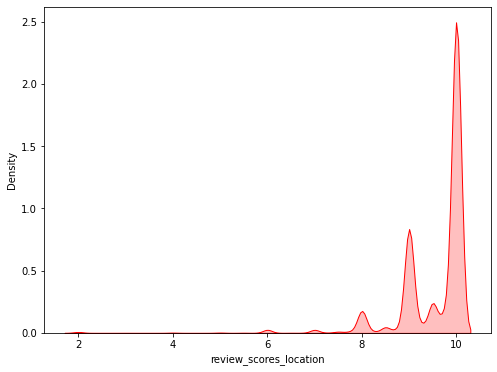

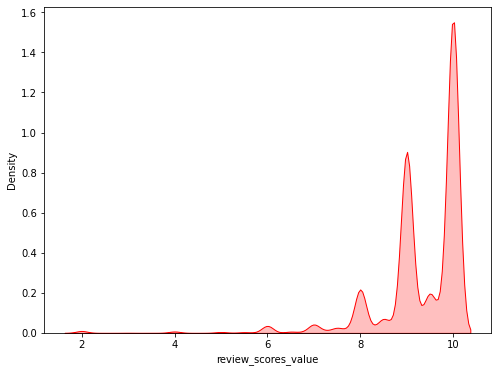

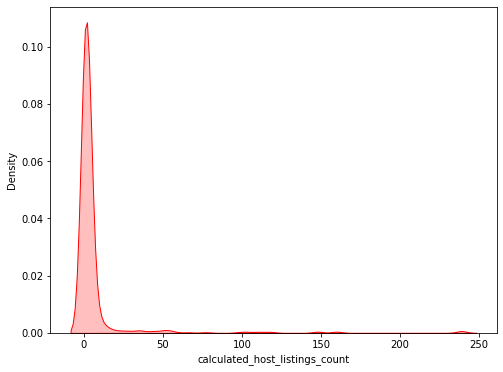

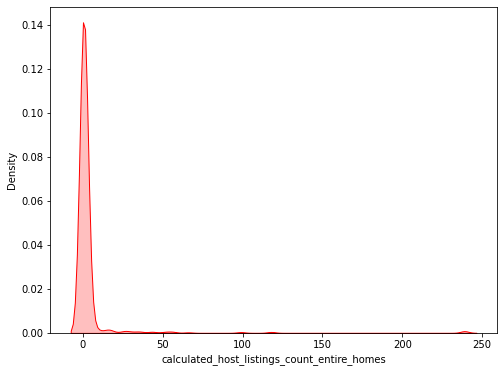

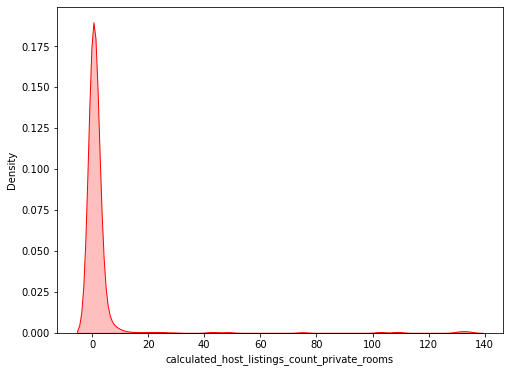

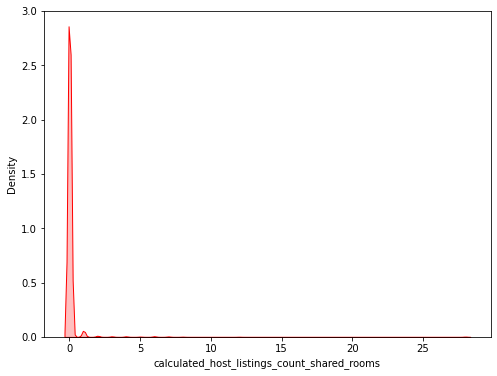

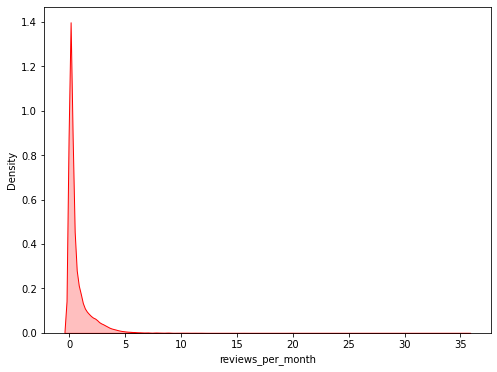

In [801]:
# KDE Plot
for col in KNNimputed_X_train.columns:
    plt.figure(figsize= (8,6))
    ax = sns.kdeplot(KNNimputed_X_train[col], shade=True, color="r")
    plt.show()

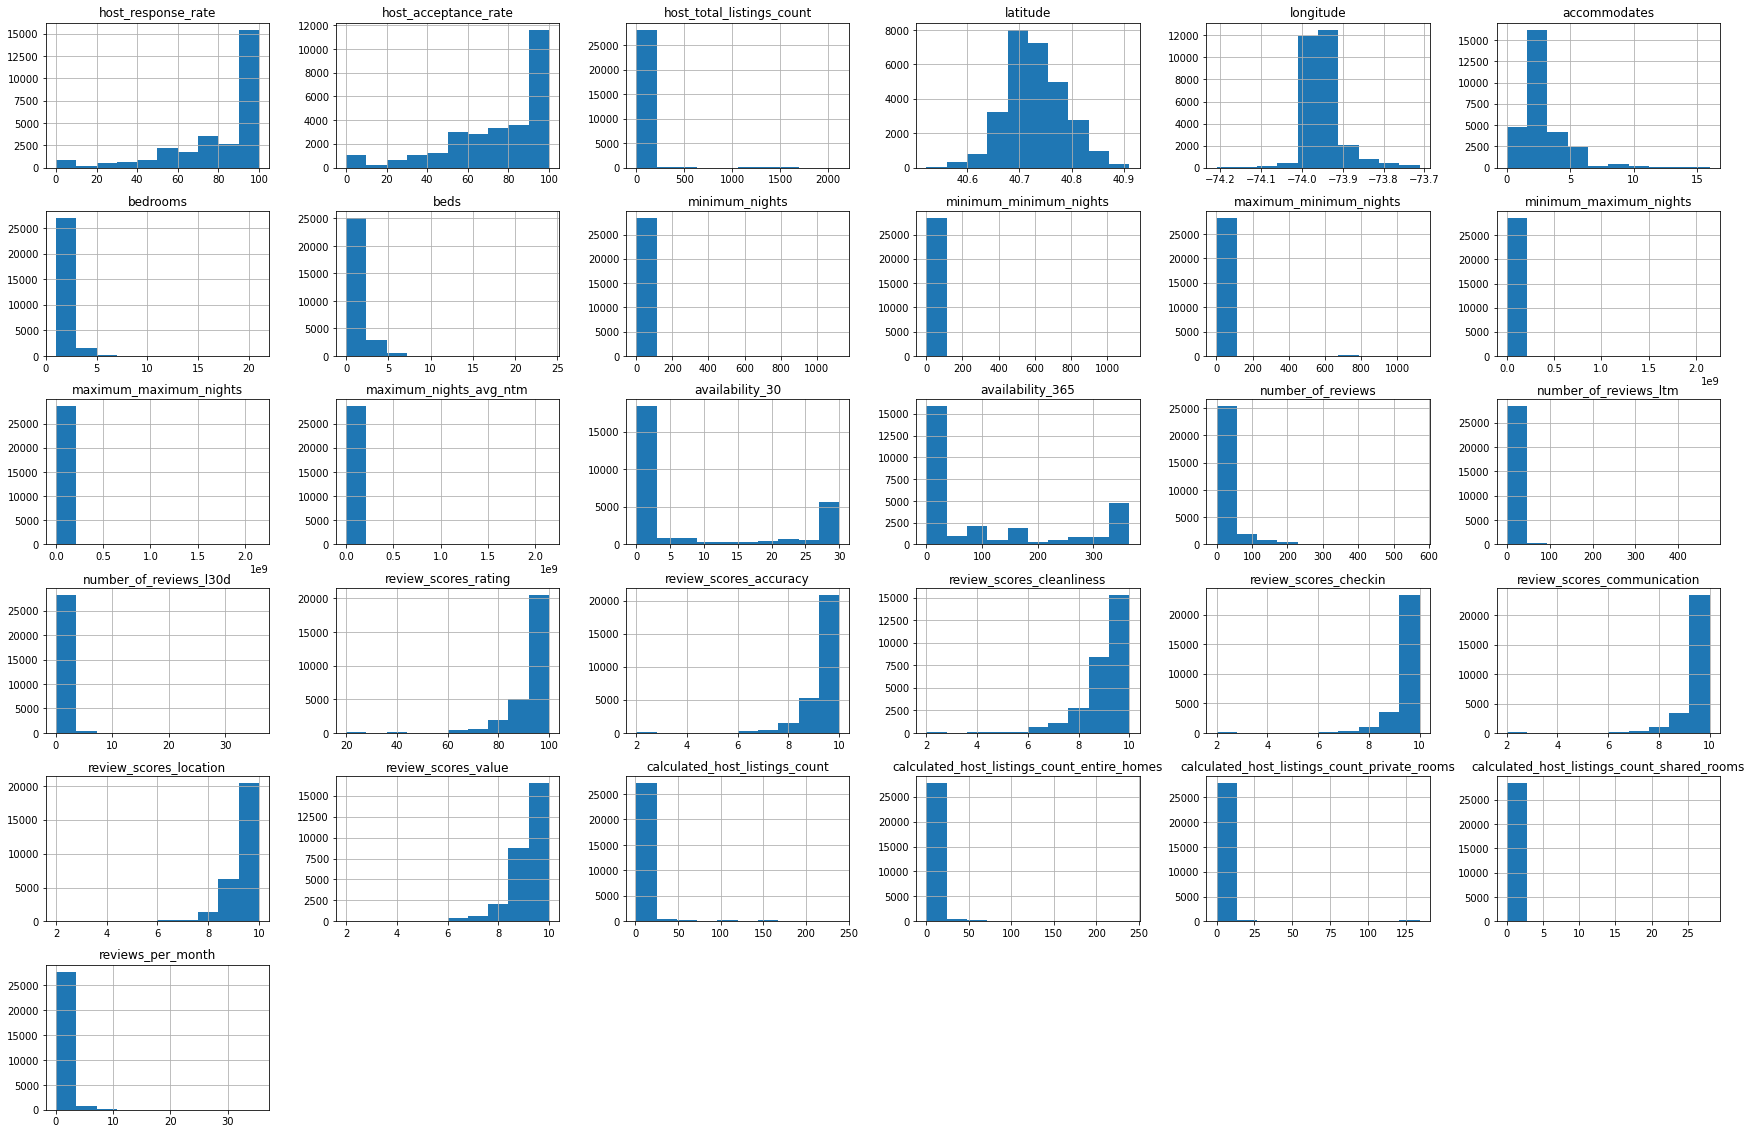

In [802]:
# Visualize histogram of dataset
KNNimputed_X_train.hist(figsize= (30,20), bins= 10)
plt.show()

In [803]:
# diagnostic plot to confirm skewness/outliers
def diagnostic_plots(df,variable):
  # functin to plot a histogram and Q-Q plot 
  
  plt.figure(figsize = (15,6))
  plt.subplot(1,2,1)
  df[variable].hist()
  
  plt.subplot(1,2,2)
  stats.probplot(df[variable], dist = "norm", plot = plt)
  
  plt.show()

<Figure size 1296x1008 with 0 Axes>

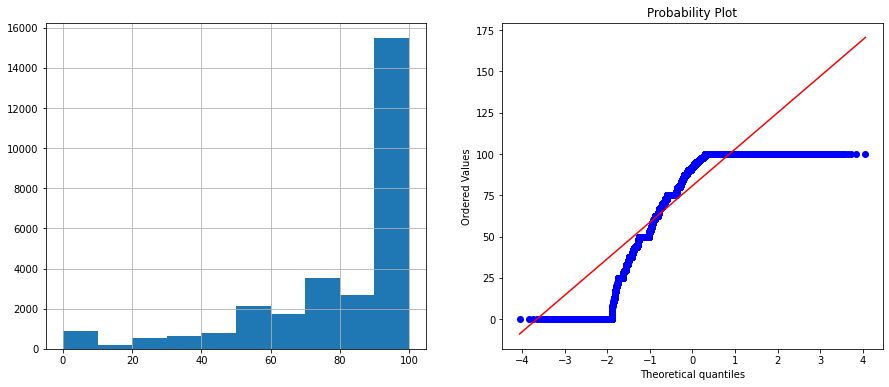

<Figure size 1296x1008 with 0 Axes>

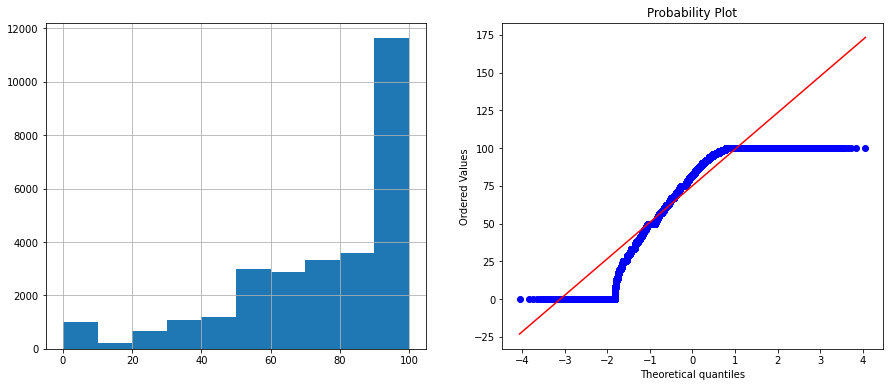

<Figure size 1296x1008 with 0 Axes>

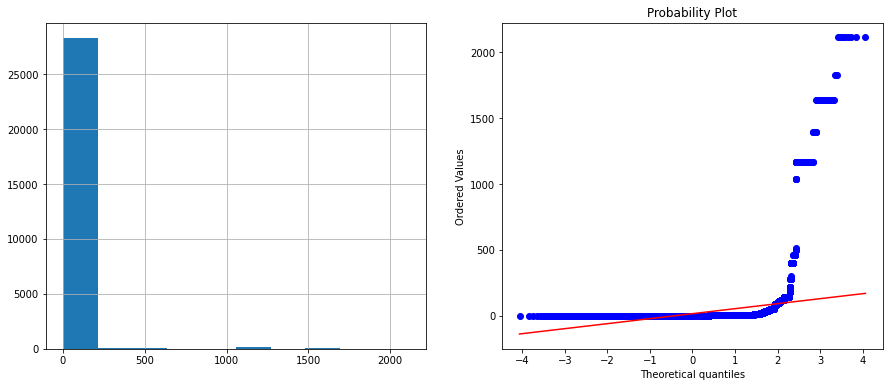

<Figure size 1296x1008 with 0 Axes>

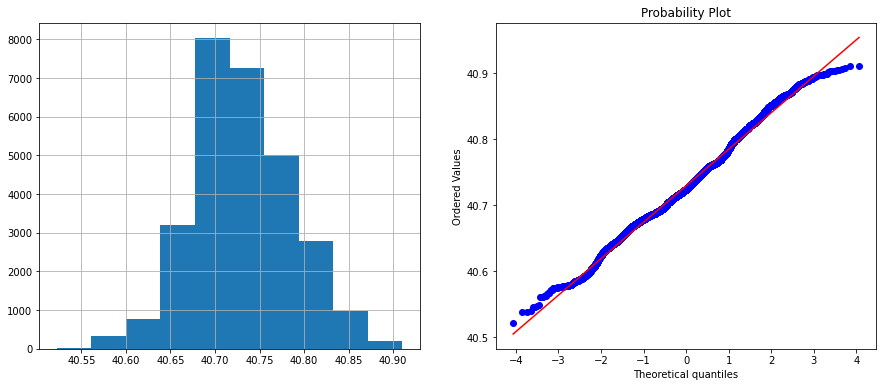

<Figure size 1296x1008 with 0 Axes>

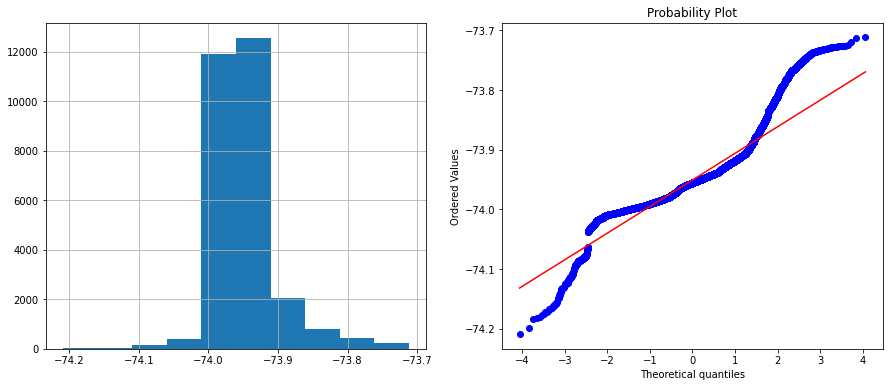

<Figure size 1296x1008 with 0 Axes>

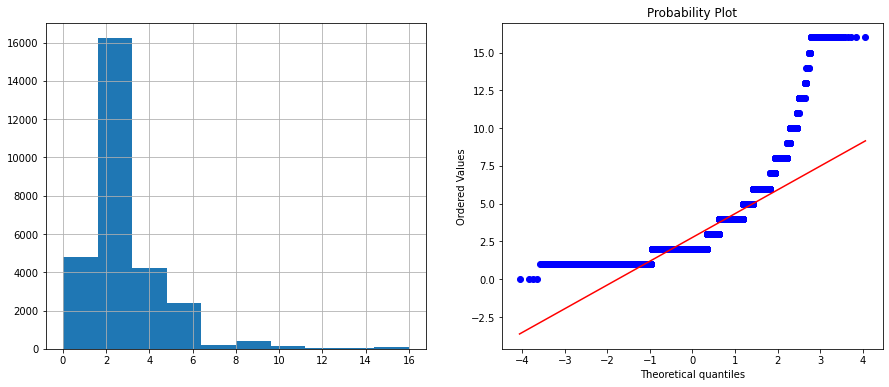

<Figure size 1296x1008 with 0 Axes>

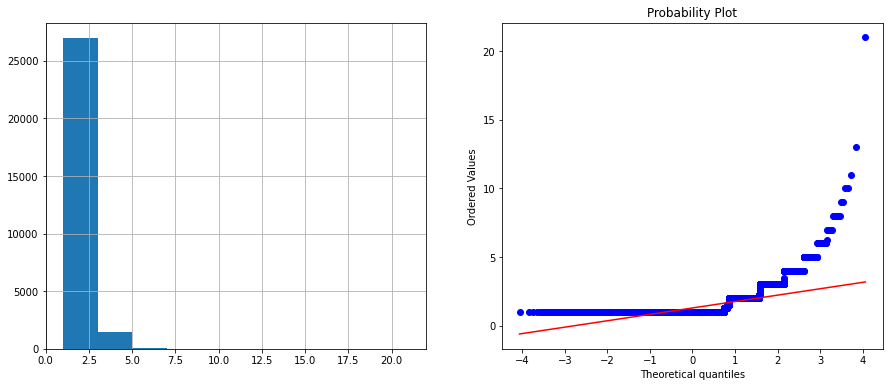

<Figure size 1296x1008 with 0 Axes>

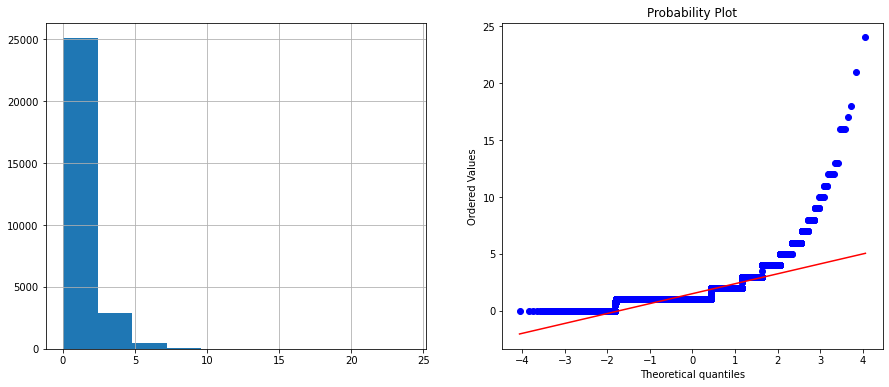

<Figure size 1296x1008 with 0 Axes>

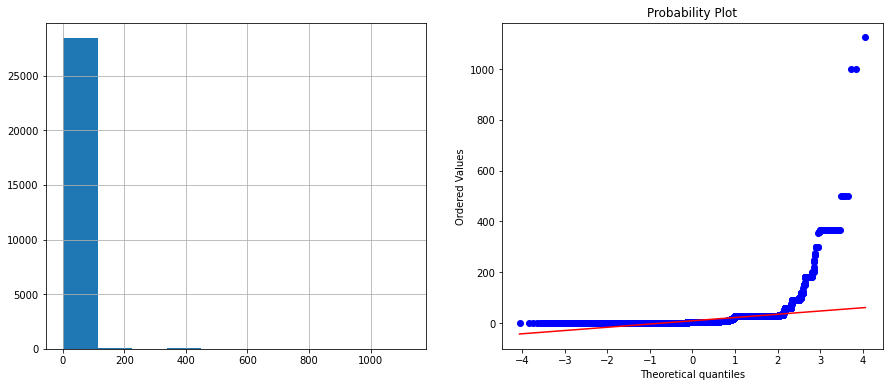

<Figure size 1296x1008 with 0 Axes>

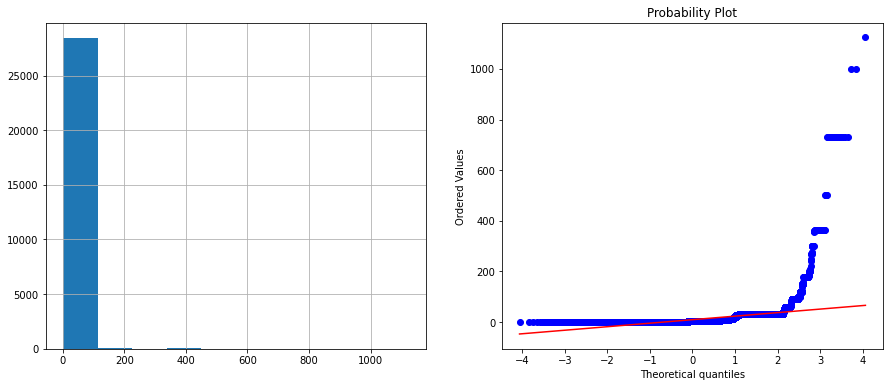

<Figure size 1296x1008 with 0 Axes>

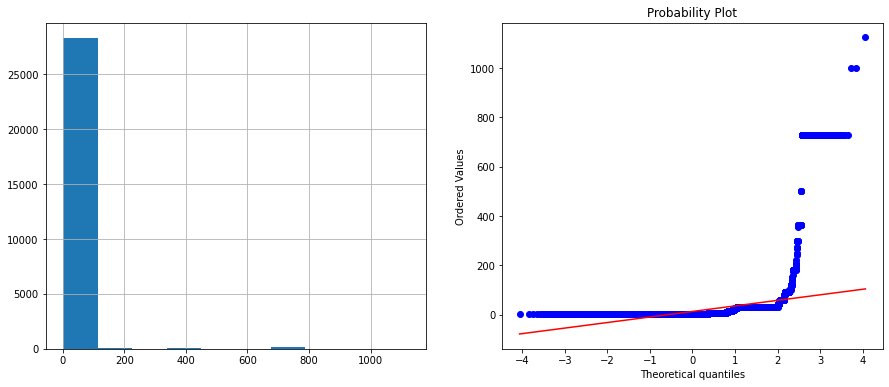

<Figure size 1296x1008 with 0 Axes>

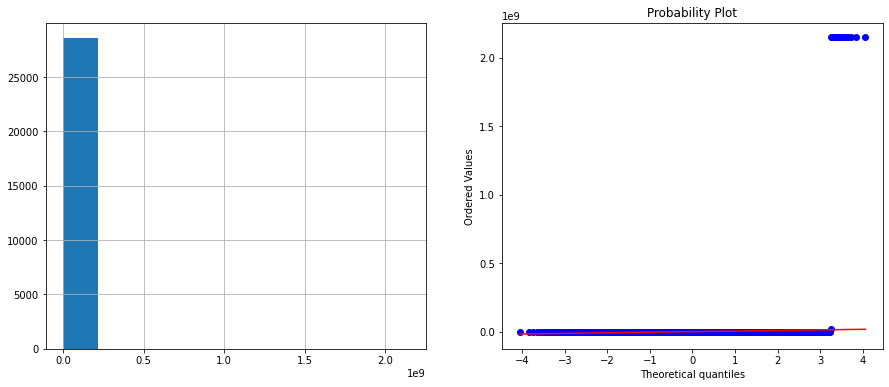

<Figure size 1296x1008 with 0 Axes>

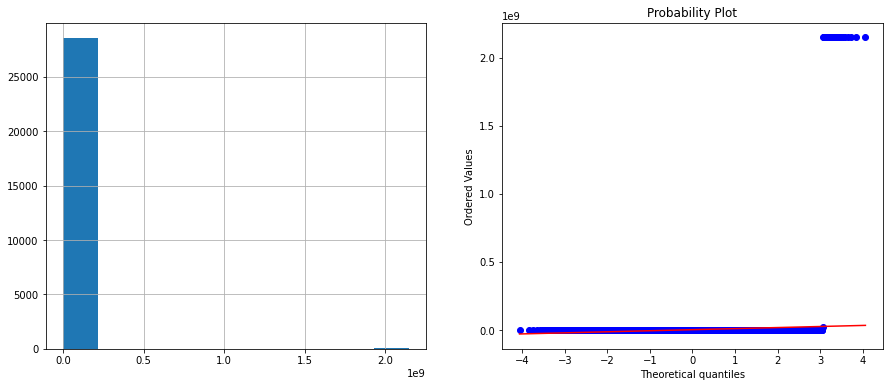

<Figure size 1296x1008 with 0 Axes>

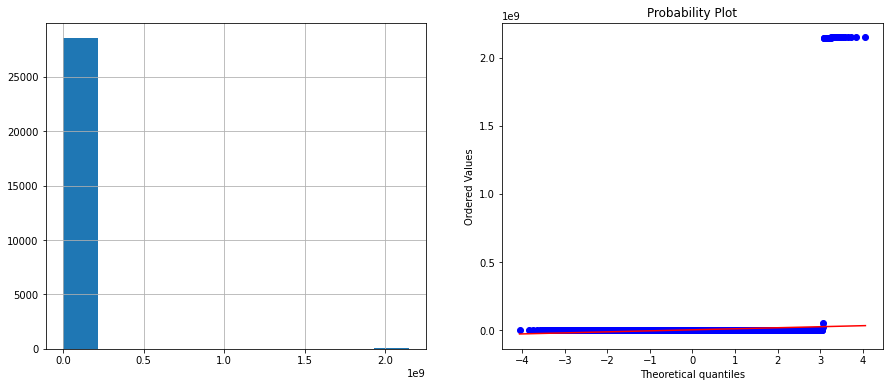

<Figure size 1296x1008 with 0 Axes>

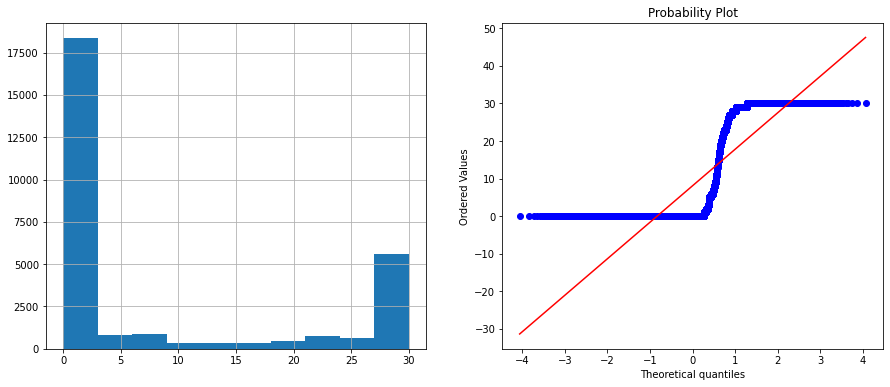

<Figure size 1296x1008 with 0 Axes>

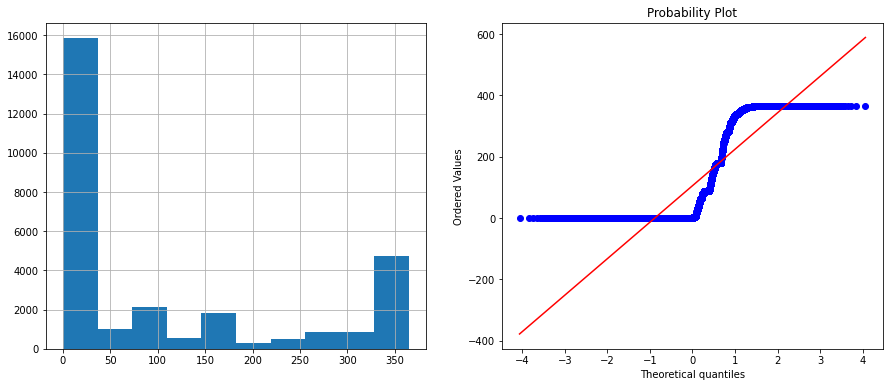

<Figure size 1296x1008 with 0 Axes>

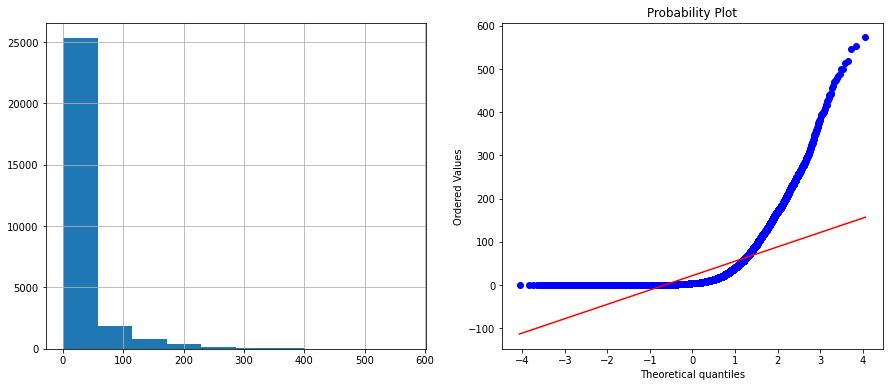

<Figure size 1296x1008 with 0 Axes>

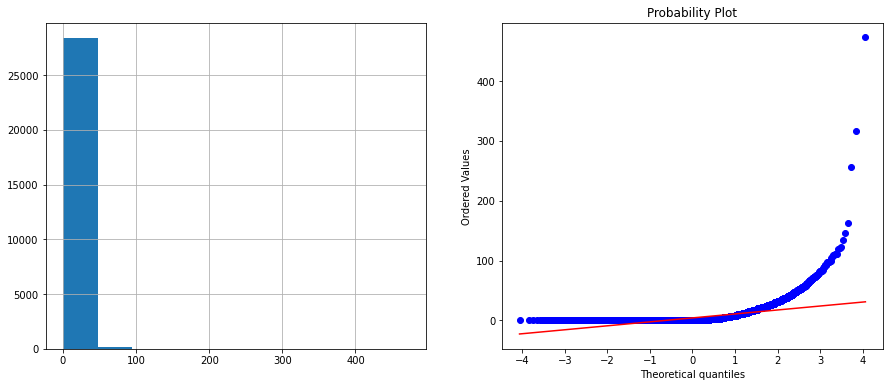

<Figure size 1296x1008 with 0 Axes>

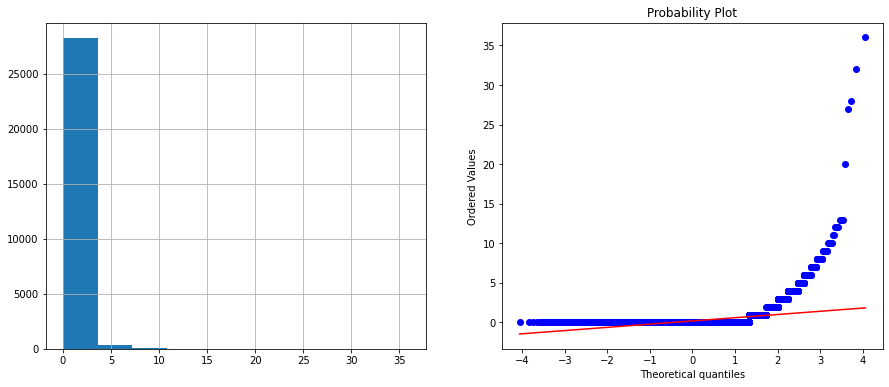

<Figure size 1296x1008 with 0 Axes>

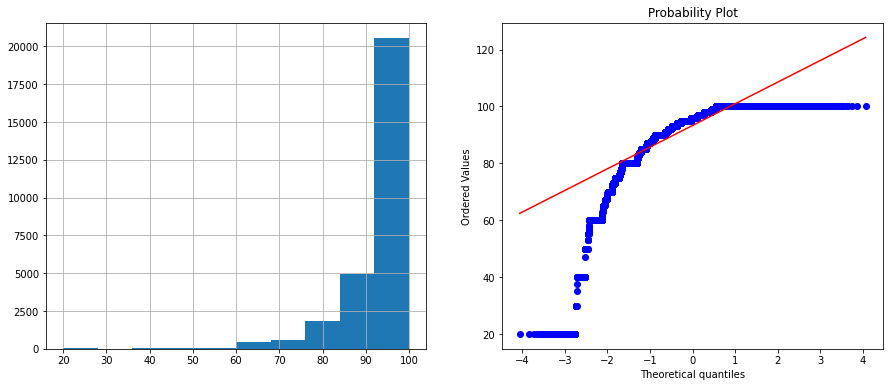

<Figure size 1296x1008 with 0 Axes>

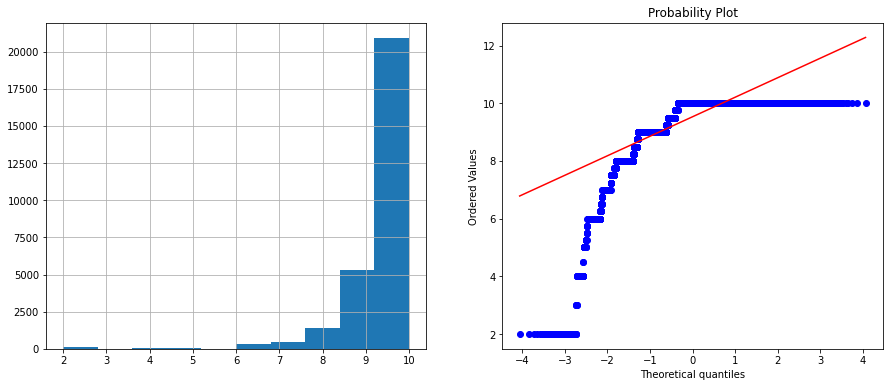

<Figure size 1296x1008 with 0 Axes>

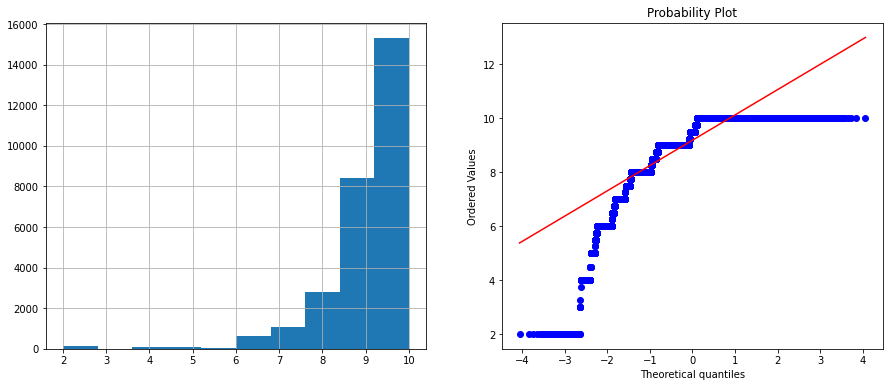

<Figure size 1296x1008 with 0 Axes>

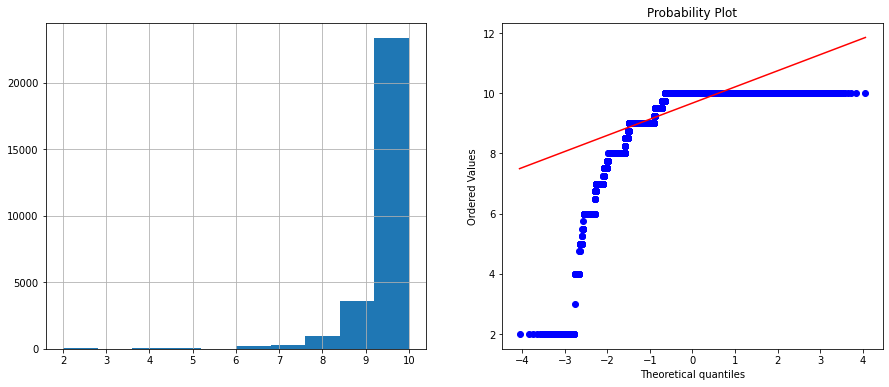

<Figure size 1296x1008 with 0 Axes>

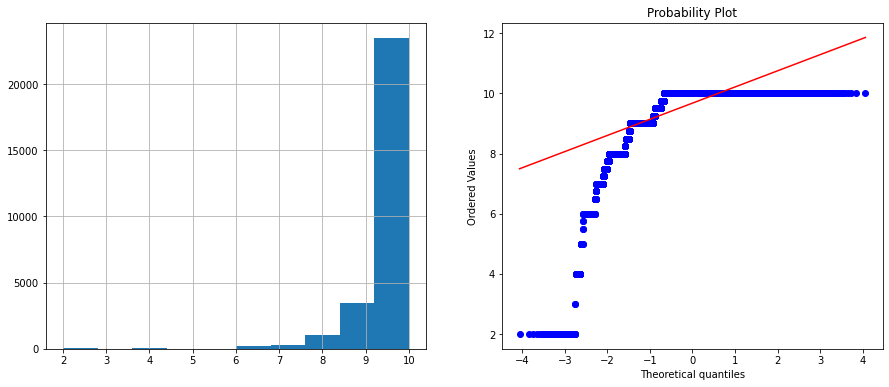

<Figure size 1296x1008 with 0 Axes>

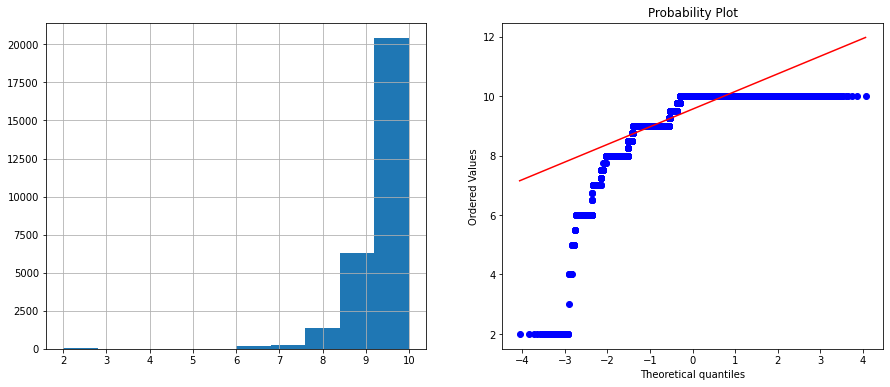

<Figure size 1296x1008 with 0 Axes>

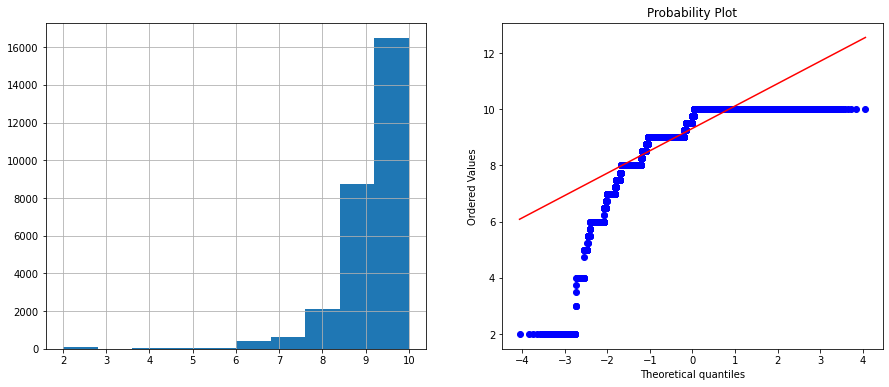

<Figure size 1296x1008 with 0 Axes>

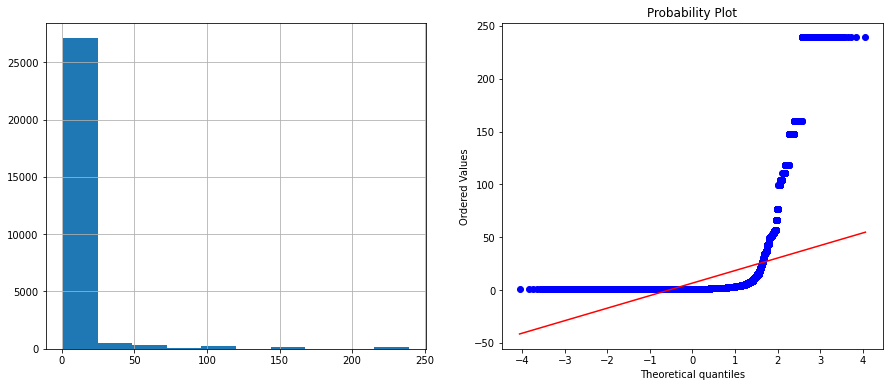

<Figure size 1296x1008 with 0 Axes>

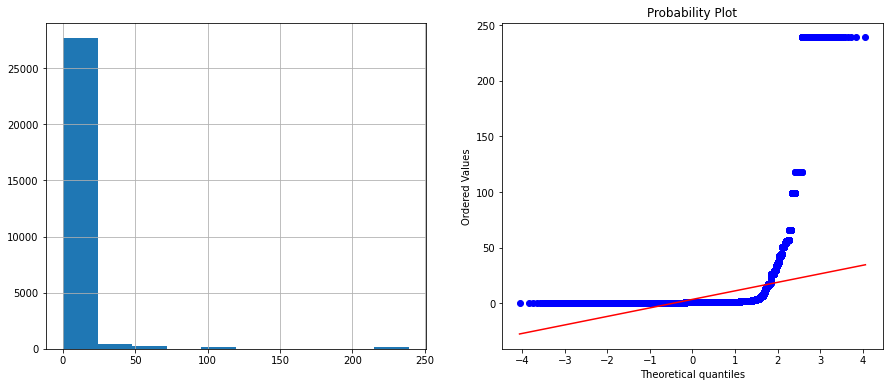

<Figure size 1296x1008 with 0 Axes>

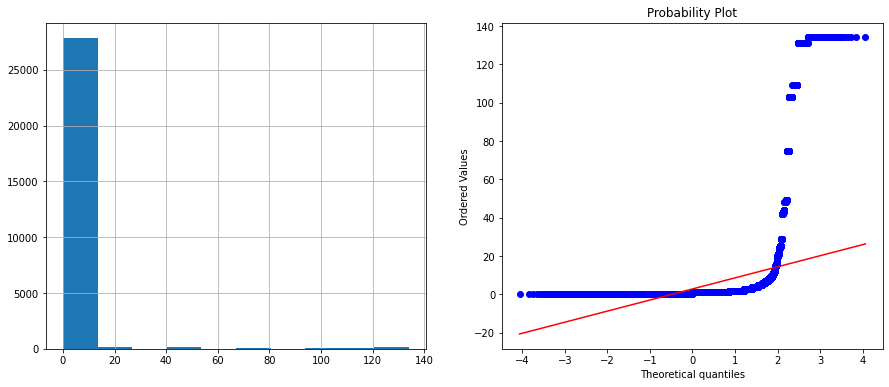

<Figure size 1296x1008 with 0 Axes>

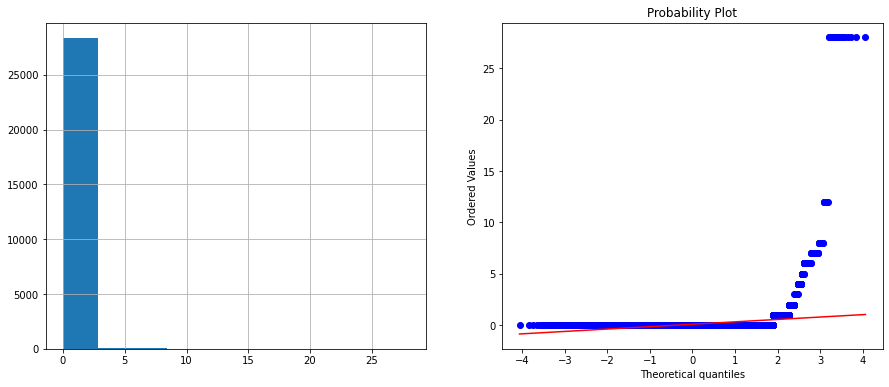

<Figure size 1296x1008 with 0 Axes>

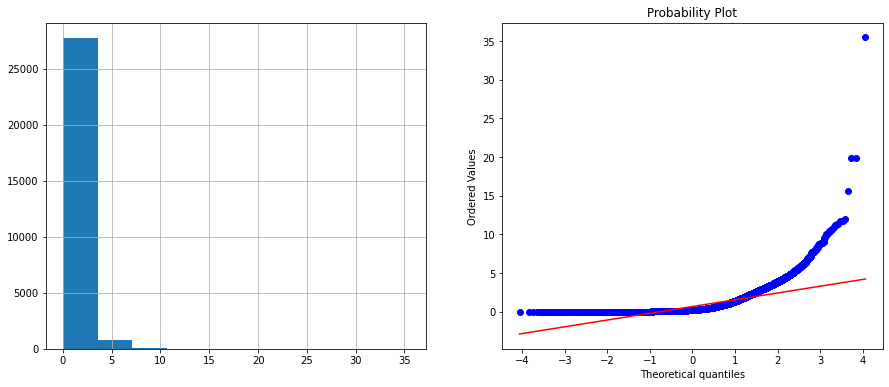

In [804]:
# Confirm skewness with Q-Q plot for all numerical columns
for i,cols in enumerate(KNNimputed_X_train.columns):
    plt.figure(i)
    diagnostic_plots(KNNimputed_X_train, cols)
    plt.show()

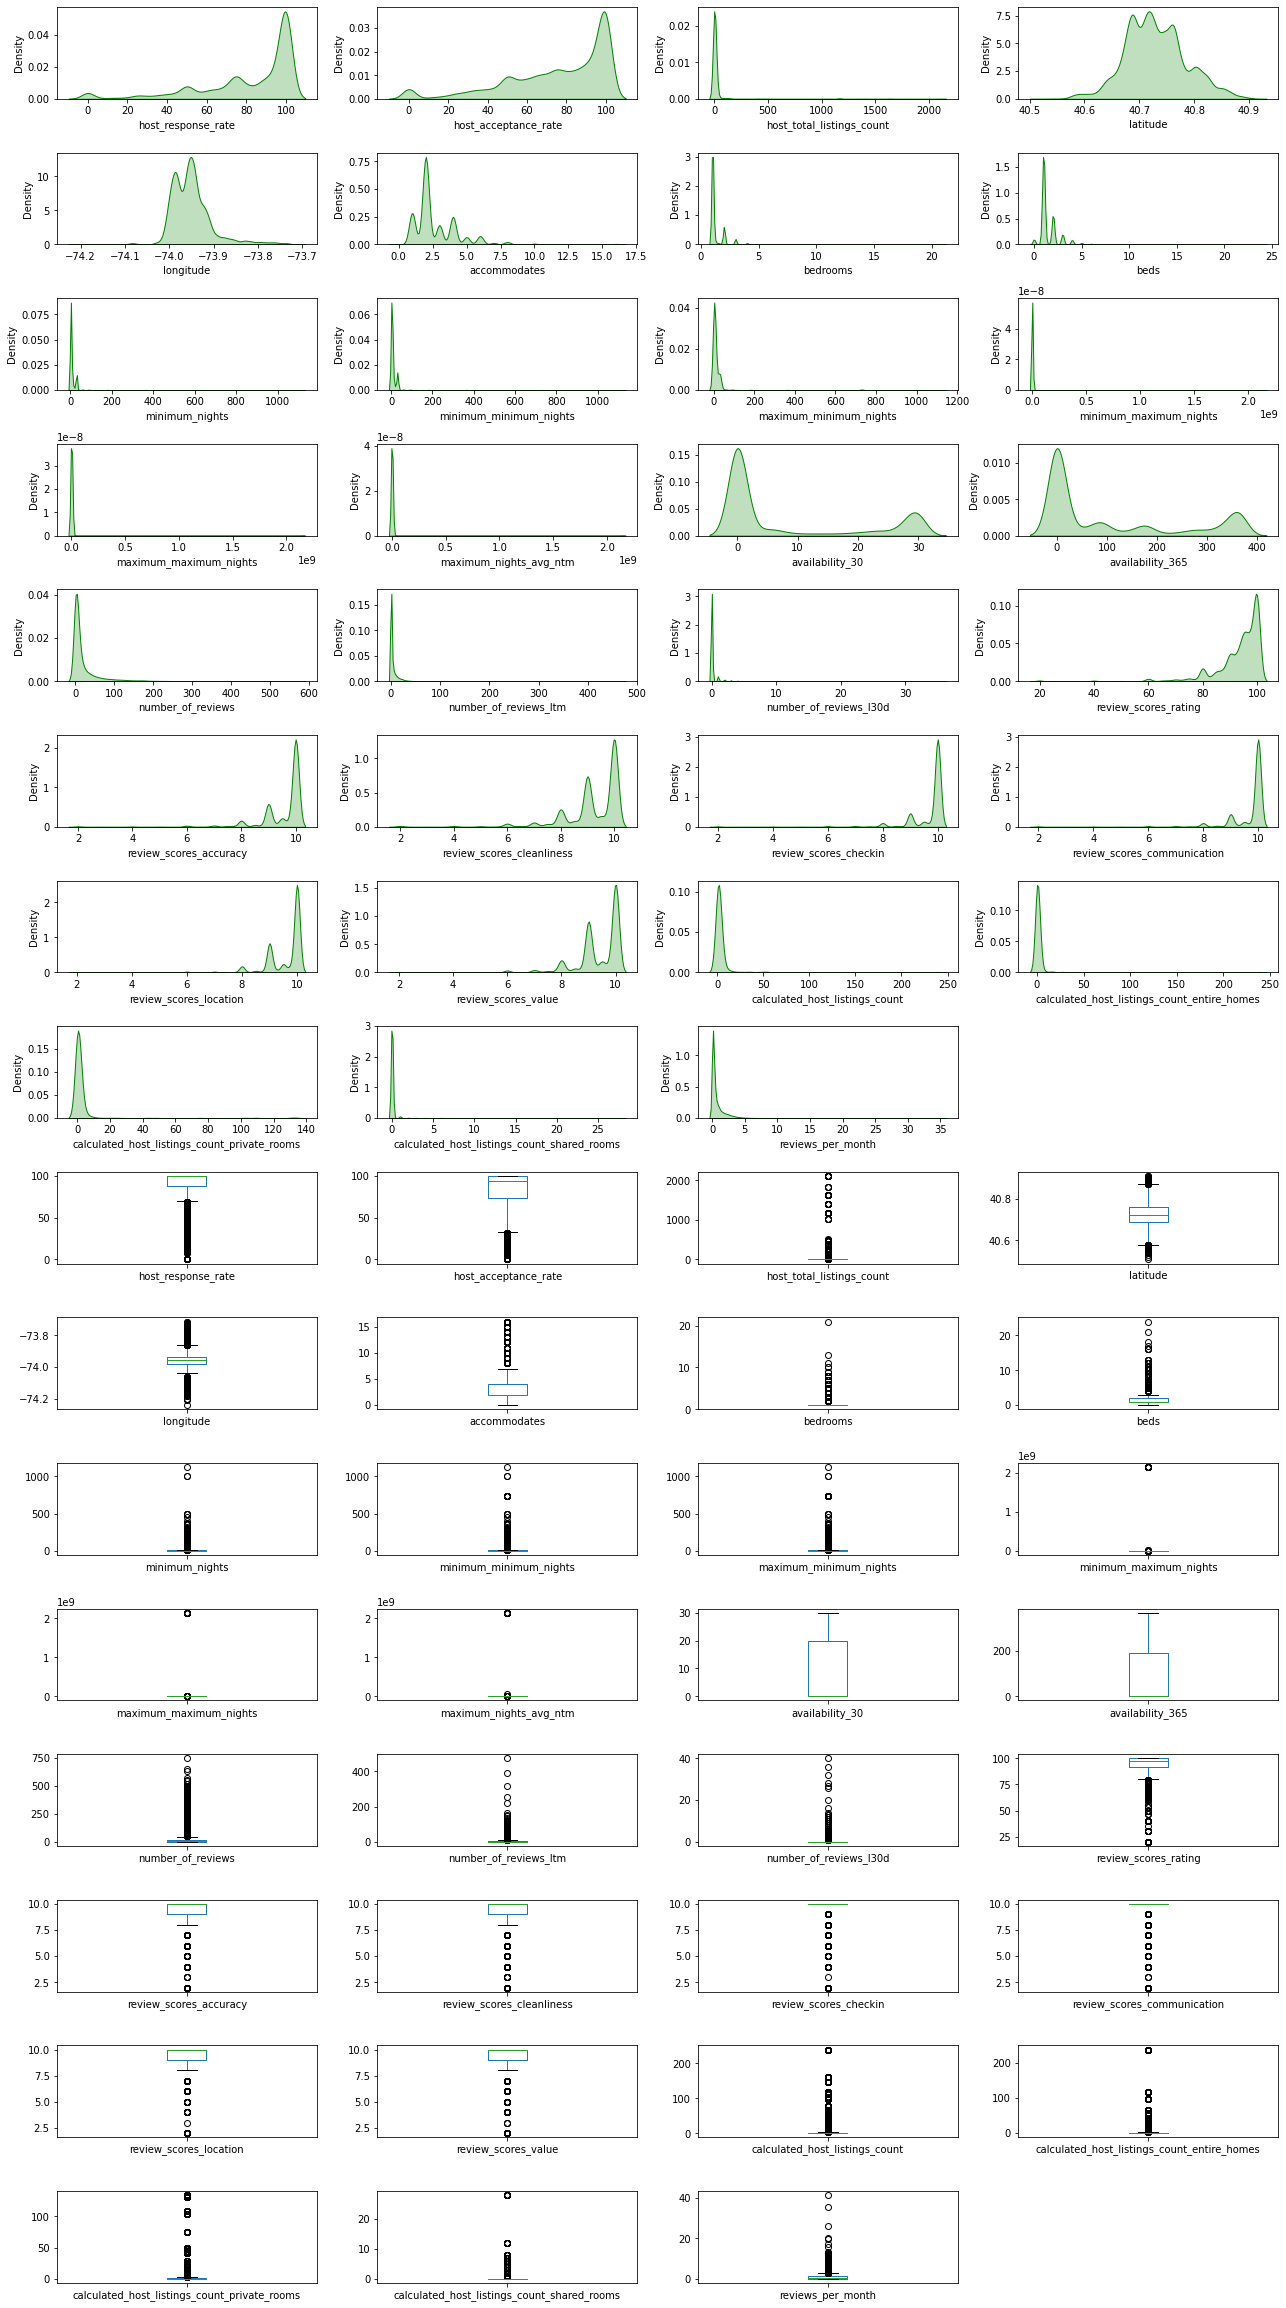

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
skewness,-1.498602,-1.104864,11.253533,0.225662,1.361188,2.596378,4.201248,3.627239,15.802610,16.947674,11.463698,42.233386,30.317559,30.819581,1.006536,0.914988,3.912339,8.984616,11.808968,-3.222399,-3.607256,-2.410454,-4.582660,-4.625808,-3.420393,-2.783336,6.678167,9.871539,7.974966,22.478763,4.327504
kurtosis,1.724223,0.617672,136.228020,0.102024,4.506373,11.227648,45.198060,29.540257,459.112667,399.140995,141.630476,1781.793075,917.221093,947.932984,-0.820748,-0.832772,20.849717,250.776015,296.403325,16.634323,19.916166,9.166619,31.204657,31.539049,21.547602,13.207271,50.297767,108.524894,65.797207,632.128539,51.805293


In [805]:
# Visual exploration of numerical colums
plt.figure(figsize= (18,40))

for i,col in enumerate(KNNimputed_X_train.columns,1):
    plt.subplot(20,4,i)
    sns.kdeplot(KNNimputed_X_train[col],color='g',shade=True)
    plt.subplot(20,4, i+len(numerical_cols))
    df_train[col].plot.box()
plt.tight_layout() 
plt.show()


num_data = KNNimputed_X_train
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [ ]:
# Import regression models from sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Let's move ahead and check for multicollinearity.
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

vif